<a href="https://colab.research.google.com/github/alokchoudharyguliya/NLP/blob/main/Neural_Machine_Translation_with_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [18]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2025-08-18 18:13:44--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8143096 (7.8M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   7.77M  4.21MB/s    in 1.8s    

2025-08-18 18:13:47 (4.21 MB/s) - ‘fra-eng.zip.1’ saved [8143096/8143096]



In [19]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
replace /content/dataset/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [40]:
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [41]:
for i in text_dataset.take(4):
  print(i)

tf.Tensor(b'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)', shape=(), dtype=string)
tf.Tensor(b'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)', shape=(), dtype=string)
tf.Tensor(b'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)', shape=(), dtype=string)
tf.Tensor(b'Go.\tBouge !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)', shape=(), dtype=string)


In [42]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=64
FRENCH_SEQUENCE_LENGTH=64
EMBEDDING_DIM=300
BATCH_SIZE=64
NUM_UNITS=256

We create the vectorization layer and later pass our text through it or provide it our text

In [53]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [54]:
english_vectorize_layer.vocabulary_size()
english_vectorize_layer.get_vocabulary()

['', '[UNK]']

In [55]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation', # lower case and remove punctuation
    max_tokens=VOCAB_SIZE,
    output_mode='int', # not multihot encoding
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [56]:
# this function is in the way that for this machine translation problem we will need two inputs
# 1. english sentence
# 2. shifted french sentence that is output of french from previous
# 3. prediction french sentence
# we add [] to start token and end token so that model does not consider them as englisht words "start token" and "end token"
def selector(input_text):
  split_text=tf.strings.split(input_text,"\t")
  return {'input_1':split_text[0:1],'input_2':'[strart token] '+split_text[1:2]},split_text[1:2]+' [end token]'

In [57]:
split_dataset=text_dataset.map(selector)

In [58]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

For the initial dataset having sentence mappings we create a new dataset having input_1, input_2 and output keys where their values are english sentence, shifted french sentence and output french sentence

In [59]:
for ind,i in enumerate(split_dataset.take(200)):
  if ind==167:
    print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Ask him.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[strart token] Demande-lui.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Demande-lui. [end token]'], dtype=object)>)


In [60]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[strart token] Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! [end token]'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[strart token] Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. [end token]'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[strart token] En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! [end token]'], dtype=object)>)


Separator simply separates the english and french sentences

In [61]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'[ start token ]'+split_text[1:2]+'[ end token ]'

In [62]:
init_dataset=text_dataset.map(separator)

In [63]:
for i in init_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[ start token ]Va ![ end token ]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[ start token ]Marche.[ end token ]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[ start token ]En route ![ end token ]'], dtype=object)>)


In [64]:
english_training_data=init_dataset.map(lambda x,y:x) # here y consists of both input_2 and output that is [start] French sentence [end]
english_vectorize_layer.adapt(english_training_data) # adapt the vectorize_layer to the training data having input_1, input_2 and output

In [65]:
french_training_data=split_dataset.map(lambda x,y:y)
french_vectorize_layer.adapt(french_training_data)

Now we hace split_dataset in  the way we want to train our model and init_dataset as english vs french sentences

In [67]:
def vectorizer(inputs, outputs):
  return {'input_1':english_vectorize_layer(inputs['input_1']),'input_2':french_vectorize_layer(inputs['input_2']),'output':french_vectorize_layer(outputs)}

The above function will return the numberized or vectorized version of our input_1 sentence, input_2 sentence and output sentence.

In [68]:
dataset=split_dataset.map(vectorizer)

In [69]:
for i in dataset.take(50):
  print(i)

{'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  1,   2, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>, 'output': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[102,   3,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  

In [70]:
english_vectorize_layer.get_vocabulary()[43]

np.str_('its')

In [72]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [73]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)#.skip(int(0.9*NUM_BATCHES))

In [74]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

### Modelling
Here our previous approach of using simple RNNs will not work, we need a Sequence to Sequence model



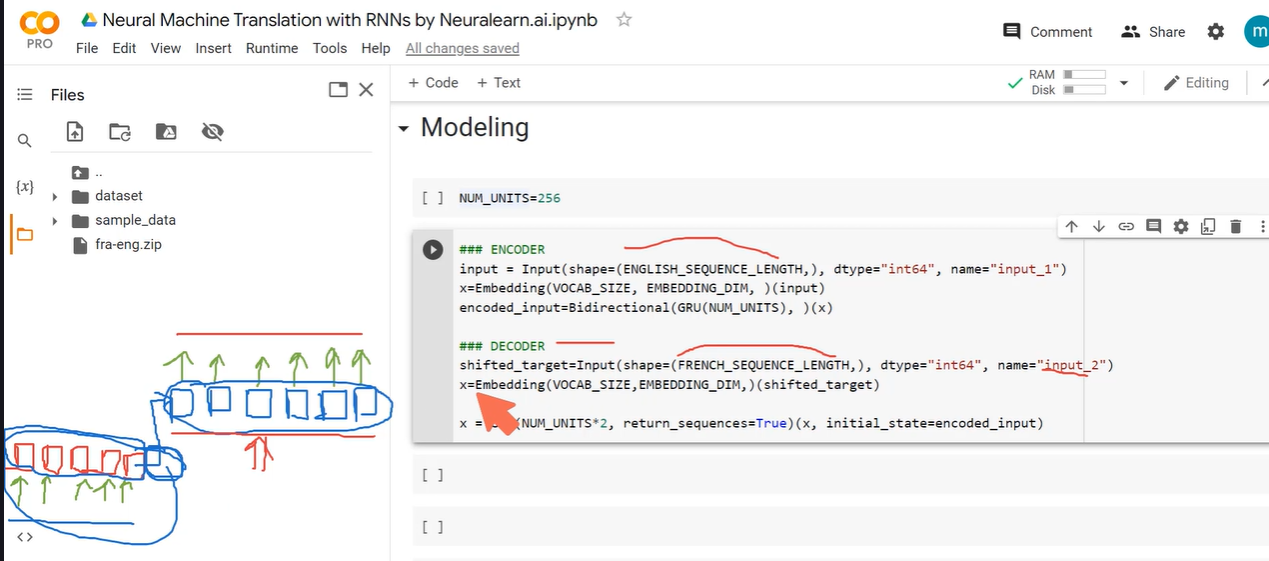

In [75]:
NUM_BATCHES=256

In [76]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.models import Model

In [77]:
# ENCODER
input=Input(shape=(ENGLISH_SEQUENCE_LENGTH,),dtype="int64",name="input_1")
x=Embedding(VOCAB_SIZE,EMBEDDING_DIM)(input)
encode_input=Bidirectional(GRU(NUM_UNITS),)(x)
# BIDIRECTIONAL_LAYER(GRU_LAYER(EMBEDDING_LAYER(INPUT_LAYER())))
### DECODER - will have shifted targets that is shifted french sentences
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH,),dtype="int64",name="input_2")
x=Embedding(VOCAB_SIZE,EMBEDDING_DIM,)(shifted_target)
x=GRU(NUM_UNITS*2,return_sequences=True)(x,initial_state=encode_input)# return_sequence = True because we need the output from every Unit a whole sentence
# Why NUM_UNITS*2 -> because we have taken Bidirectional GRU RNN above
# num_units*2 because from encoder there are two outputs due to bidirectional nature
# GRU_LAYER(EMBEDDING_LAYER(INPUT_LAYER()))
## OUTPUT
x=Dropout(0.5)(x)
target=Dense(VOCAB_SIZE,activation="softmax")(x) # Why the number of output be VOCAB_SIZE? we are predicting probability of each word to come at that place,
# output will be VOCAB_SIZE dimensional
seq2seq_gru=Model([input,shifted_target],target)
seq2seq_gru.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 64, 300)   │  6,000,000 │ input_1[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 64, 300)   │  6,000,000 │ input_2[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 512)       │    857,088 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 64, 512)   │  1,250,304 │ embedding_3[0][0… │
│                     │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 512)   │          0 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 20000) │ 10,260,000 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,367,392 (92.95 MB)

 Trainable params: 24,367,392 (92.95 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
class BLEU(tf.keras.metrics.Metric):
  def __init__(self,name="bleu_score")
    super(BLEU,self).__init__()
    self.bleu_score=0
  def update_state(self,y_true,y_pred,sample_weight=None):
    y_pred=tf.argmax(y_pred,-1)
    self.bleu_score=0
    for i, j in zip(y_pred,y_true):
      tf.autograph.experimental.set_loop_options()
      total_words=tf.math.count_nonzero(i)
      total_matches=0
      for word in i:
        if word==0:
          break
        for q in range(len(j)):
          if j[q]==0:
            break
          if word==j[q]:
            total_matches+=1
            j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
            break
        self.bleu_score+=total_matches/total_words
  def result(self):
    return self.bleu_score/BATCH_SIZE

SyntaxError: expected ':' (ipython-input-4270671923.py, line 2)

Compiling the seq2seq model

In [ ]:
seq2seq_gru.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimzers.Adam(5e-4),
                    metrics=[BLEU()],
                    run_eagerly=True)

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/nlp/translation/lstm.h5"
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
history=seq2seq_gru.fit(
    train_dataset,validation_data=val_dataset,epochs=20,
    callbacks=[model_checkpoint_callback]
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
seq2seq_gru.evaluate(val_dataset)

### Testing

In [ ]:
index_to_word={x:y for x,y in zip(range(len(french_vectorize_layer.get_vocabulary())),french_vectorize_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
